# Home Loan Analysis

## Introduction

The dataset consists of a representative sample of a home-loan portfolio and contains 59,477 rows and 20 columns. A data dictionary explaining the key features is shown on the next page. There is no indication of the customers past repayment behaviour (i.e. it is an unlabelled dataset).

## Libraries

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.spatial

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, log_loss, brier_score_loss, silhouette_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from yellowbrick.cluster import silhouette_visualizer


import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"


## Functions

In [ ]:
def check_duplicates(data:pd.DataFrame, cols:list):
    # checking duplicate value

    for feature in cols:
        _col = data[feature]
        _len = len(_col)
        _unique = len(set(_col))
        if (_len/_unique) == 1:
            print('Values in the column {} are unique. No duplicates found.\n'.format(feature))
        else:
            s = data[feature].value_counts()
            print('Values in the column {} are not unique. Duplicates and frequencies:'.format(feature))
            print(s.where(s>1).dropna())
            print('\n')

def show_multivariate_boxplot(data:pd.DataFrame = None, layout:set = (5,5), figsize:set = (10,10), target='Employment Type'):
    x, y = layout

    fig, axes = plt.subplots(ncols=x, nrows=y, figsize=figsize)

    # Identify non-numerical features
    numerical_col_list = list(data.select_dtypes(include=["number"]).columns)
    columns = numerical_col_list + [target]
    _data = data[columns]

    # Loop through features and put each subplot on a matplotlib axis object
    for col, ax in zip(numerical_col_list, axes.ravel()):
        sns.boxplot(data=_data, x=target, y=col, ax=ax)

    plt.show()

def show_numerical_variable_boxplot(data:pd.DataFrame = None, layout:set = (5,5), figsize:set = (10,10)):
    ## Visualize the distribution
    data.select_dtypes(include='number').plot(kind="box", subplots=True, layout=layout, figsize=figsize)
    plt.tight_layout()

def create_dummy_table(data:pd.DataFrame, remove_columns:list=None, numerical_cols:list=None, non_numerical_cols:list=None)->pd.DataFrame:
    ## Create dummy data

    # Copy
    dummy_df = data.copy()
    # Delete data
    del data

    if remove_columns is not None:
        dummy_df.drop(remove_columns, axis=1, inplace=True)

    if numerical_cols is None:
        numerical_cols = dummy_df.select_dtypes(include='number').columns
        dummy_df[numerical_cols] = (
            (dummy_df[numerical_cols] - dummy_df[numerical_cols].min()) / (dummy_df[numerical_cols].max() - dummy_df[numerical_cols].min())
        )

    if non_numerical_cols is None:
        non_numerical_cols = dummy_df.select_dtypes(exclude='number').columns
        for features in non_numerical_cols:
            _feature_dummies = pd.get_dummies(dummy_df[features], prefix = features)
            dummy_df = pd.concat([dummy_df, _feature_dummies], axis = 1)
            dummy_df.drop(features, axis = 1, inplace = True)

    return dummy_df

## Importing the data
The dataset consists of a representative sample of a home-loan portfolio and contains 59,477 rows and 20 columns. A data dictionary explaining the key features is shown on the next page. There is no indication of the customers past repayment behaviour (i.e. it is an unlabelled dataset).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tech Test Interview/WorkSample.csv')

In [ ]:
print(df.head())

   UniqueID  Loan To Value  Branch ID  Age Employment Type DisbursalDate  \
0    537409          73.23         67   33   Self employed    26/09/2018   
1    624493          88.48         67   25   Self employed    26/10/2018   
2    518279          89.66         67   28   Self employed    19/09/2018   
3    510278          71.89         67   29        Salaried    16/09/2018   
4    490213          89.56         67   27   Self employed    05/09/2018   

   State_ID   State  Employee_code_ID  Mobile Avl Flag  ...  \
0       NaN  Nevada              1998                1  ...   
1       NaN  Nevada              1998                1  ...   
2       NaN  Nevada              1998                1  ...   
3       NaN  Nevada              1998                1  ...   
4       NaN  Nevada              1998                1  ...   

   Number of Active Accounts  Number of Overdue Accounts  \
0                        1.0                           1   
1                        0.0                

## Structure checking

In [ ]:
print(df.shape)

(59477, 23)


In [ ]:
pd.value_counts(df.dtypes)

int64      17
float64     3
object      3
dtype: int64

### Non-numerical

In [ ]:
# Display non-numerical features
df.select_dtypes(exclude="number").head()

Employment Type DisbursalDate   State
0   Self employed    26/09/2018  Nevada
1   Self employed    26/10/2018  Nevada
2   Self employed    19/09/2018  Nevada
3        Salaried    16/09/2018  Nevada
4   Self employed    05/09/2018  Nevada

In [ ]:
# Investigate how many unique values each non-numerical feature has and with which frequency the most prominent value is present
df.describe(exclude="number").transpose()

count unique            top   freq
Employment Type  53626      3  Self employed  28094
DisbursalDate    59477     84     31/10/2018   2211
State            59477     20      Louisiana  14820

In [ ]:
# Change data type of DisbursalDate into date type
df.loc[:, "DisbursalDate"] = pd.to_datetime(df["DisbursalDate"])

<ipython-input-9-bb6b5c6b975b>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df.loc[:, "DisbursalDate"] = pd.to_datetime(df["DisbursalDate"])
<ipython-input-9-bb6b5c6b975b>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "DisbursalDate"] = pd.to_datetime(df["DisbursalDate"])


In [ ]:
df['DisbursalDate'].min(), df['DisbursalDate'].max()

(Timestamp('2018-01-08 00:00:00'), Timestamp('2018-12-10 00:00:00'))

**Conclusions:** No incorrect data type for non-numerical values; There are several missing values in the employment type

### Numerical

We want to invastigate how many unique values each of these feature has. This process will give us some insights about the number of binary (2 unique values), ordinal (3 to ~10 unique values) and continuous (more than 10 unique values) features in the datase

<Axes: title={'center': 'Unique values per feature'}>

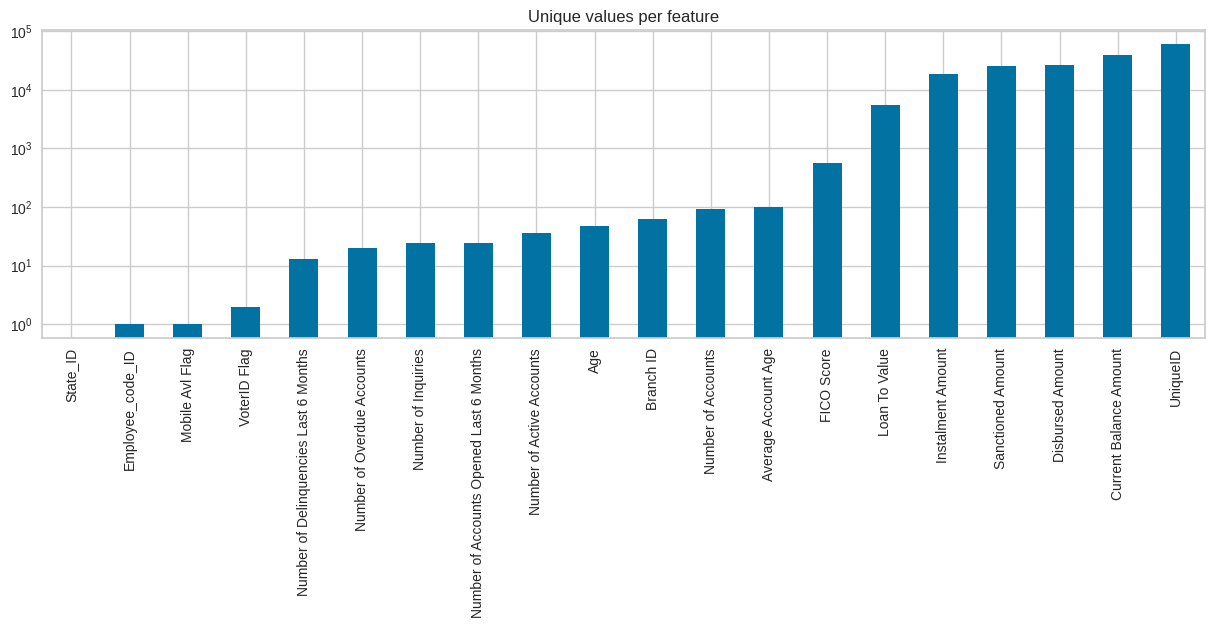

In [ ]:
# For each numerical feature compute number of unique entries
unique_values_df = df.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values_df.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature")

**Conclusions**: State_ID has no value; Employee_code_ID & Mobile Avl Flag only have 1 value; VoterID Flag is binary value and the rest are continous values
<br>
**Next action**: Drop State_ID, Employee_code_ID, Branch ID & Mobile Avl Flag

## Quality Checking

We want to have a global view on the dataset with regards to things like duplicates, missing values and unwanted entries or recording errors

### Duplicates

In [ ]:
#Count total duplicates in identifier columns
unique_cols = ['UniqueID']
check_duplicates(data=df, cols=unique_cols)

Values in the column UniqueID are not unique. Duplicates and frequencies:
537409    11.0
489281     6.0
Name: UniqueID, dtype: float64




In [ ]:
#Checking for duplicates
df[df['UniqueID'].isin([537409,489281])].sort_values('UniqueID').select_dtypes(include='number').shape

(17, 20)

**Action plan**: Drop those ids wouldn't have any impact bcs they obviously must be an unique value and they only have few rows

### Missing values

We want to look at the number of missing values per feature

<Axes: title={'center': 'Percentage of missing values per feature'}, ylabel='Ratio of missing values per feature'>

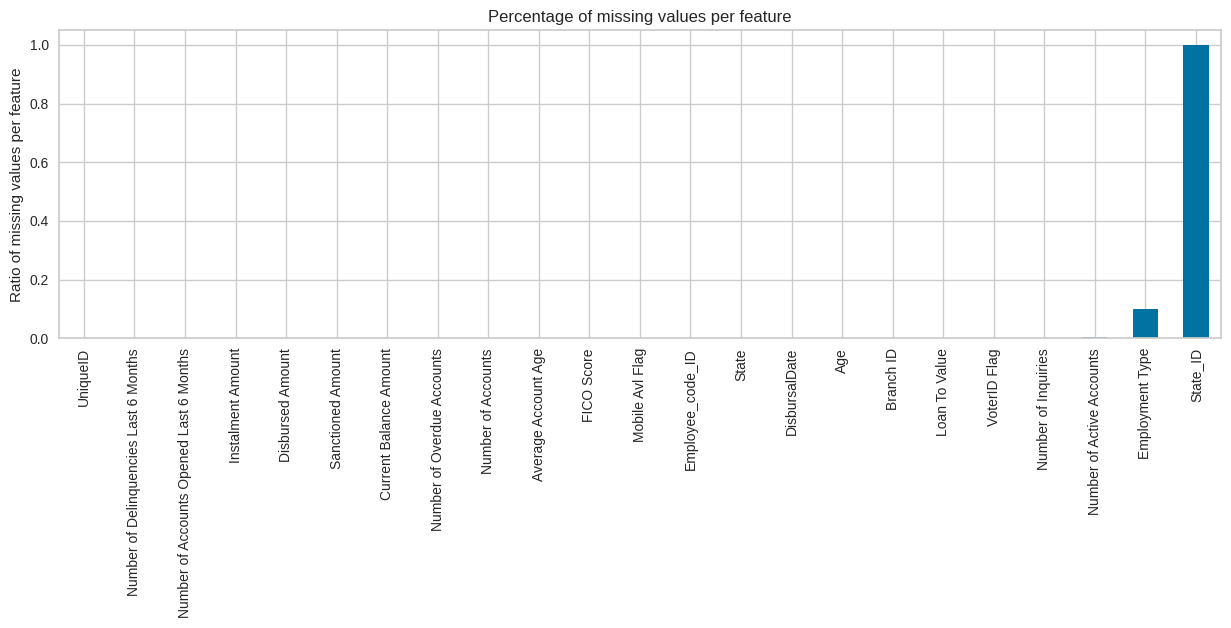

In [ ]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature")

**Conclutions**: We have a few columns that contain missing values. We won't drop 'Employment Type' and 'Number of Active Accounts'; instead,  we will perform EDA to male assumptions about whether we should input the missing values using similar entries or not
<br>
**Action plan**: Drop State_ID

## Data Cleaning

### Remove rows with UniqueID are 537409 and 489281

In [ ]:
# Drop values

df = df[~(df['UniqueID'].isin([537409,489281]))].copy()

### Remove obviously unnecessary features

Such as identifier columns and also those columns which have only 1 value

In [ ]:
df = df.drop(['UniqueID', 'State_ID', 'Employee_code_ID', 'Branch ID', 'Mobile Avl Flag'], axis=1)

## Exploratory Data Analysis

### Checking numerical attributes which are correlated with Employment Type

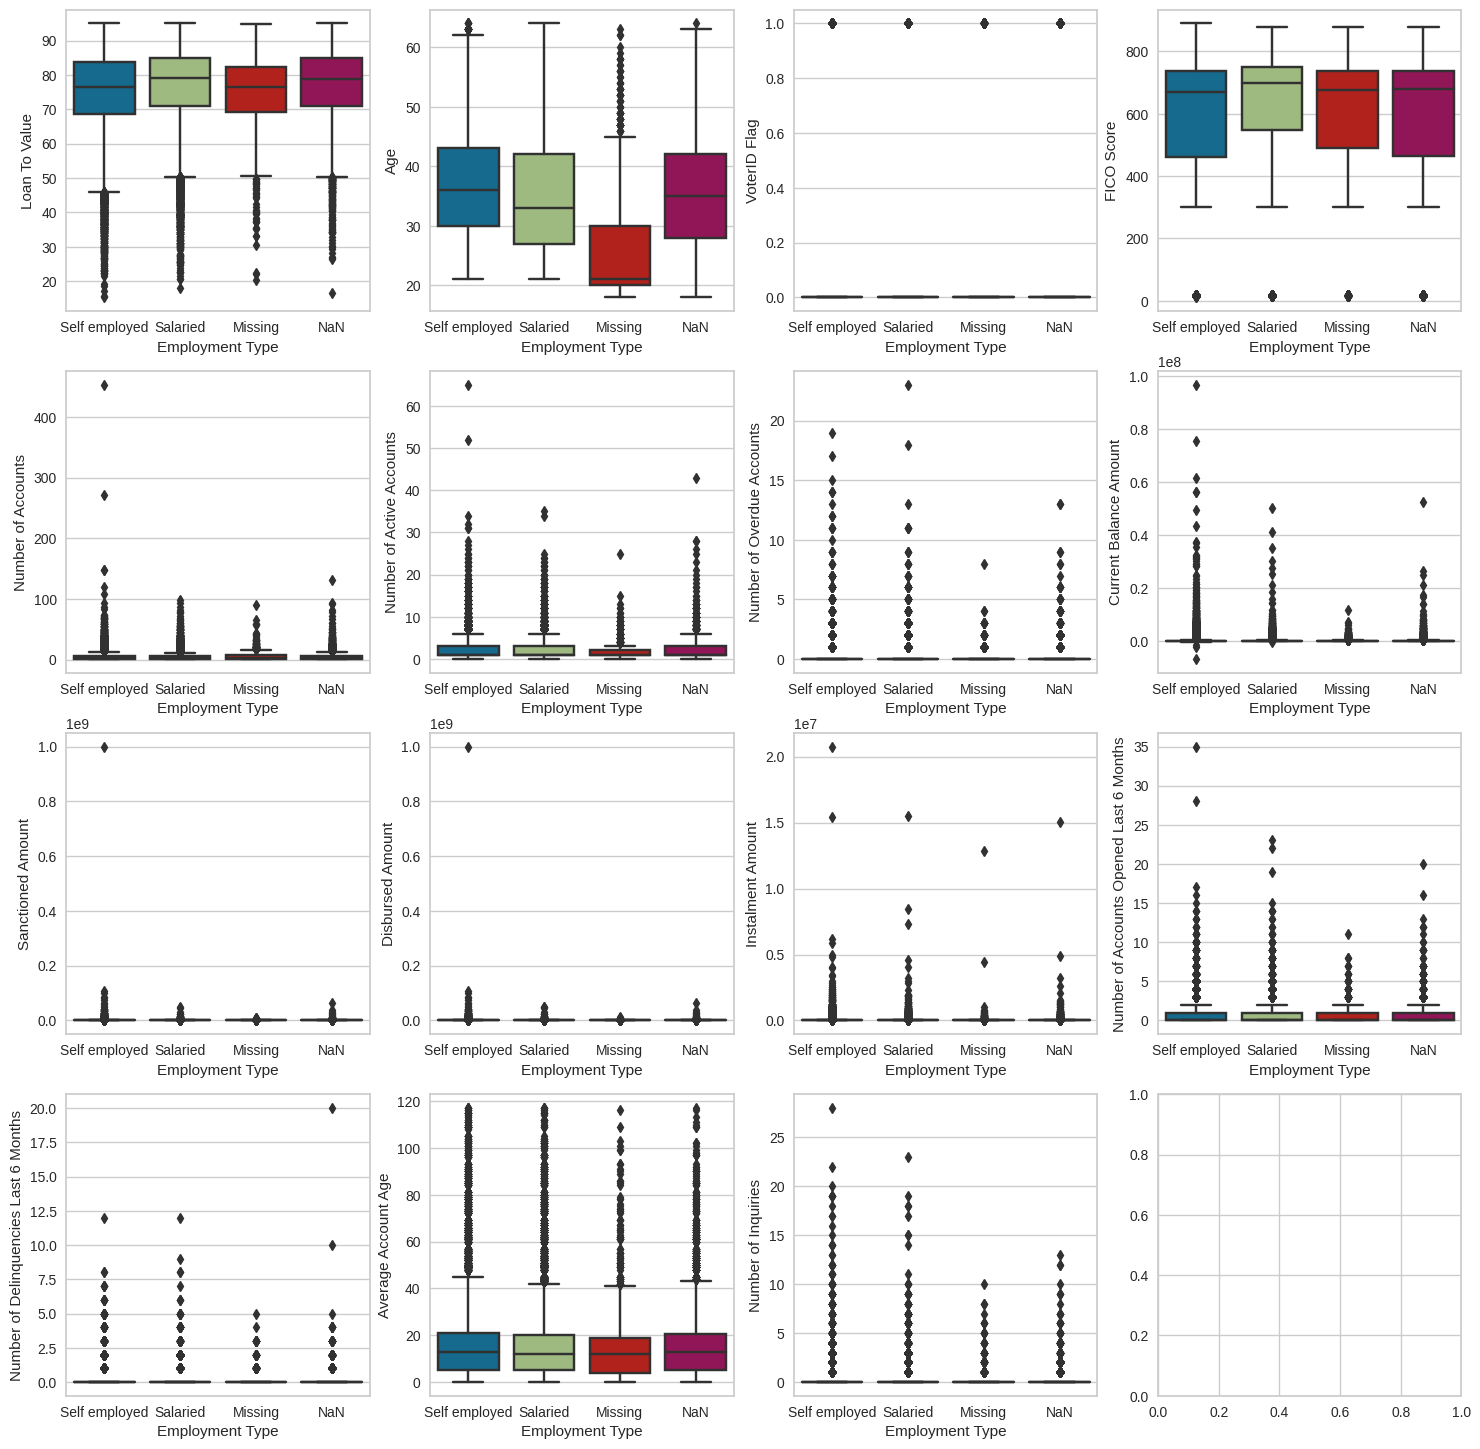

In [ ]:
df_employment = df.copy()
df_employment['Employment Type'] = df_employment['Employment Type'].fillna('NaN')
show_multivariate_boxplot(data=df_employment, layout=(4,4), figsize=(18,18), target='Employment Type')

In [ ]:
## Employment Type vs Age
fig = px.box(df_employment, x="Employment Type", y="Age")
fig.show()

In [ ]:
## Employment Type vs Fico Score
fig = px.box(df_employment, x="Employment Type", y="FICO Score")
fig.show()

In [ ]:
## Employment Type vs Fico Score
fig = px.box(df_employment, x="Employment Type", y="Loan To Value")
fig.show()

**Conclusion**:
1. The "Missing" value in Employment Type indicates that these users are likely younger individuals who probably do not have any current employment
2. If we assume that the "Missing" values represent young people, salaried individuals likely have higher FICO Scores compared to self-employed individuals and young people. The same pattern applies to Loan To Value
<br>
**Action plan**: We will fill the NaN values with 'Missing'

### Checking Number of Active Accounts column

In [ ]:
fig = px.box(df, x="Number of Active Accounts")
fig.show()

**Conclusion**: Since it is a continuous variable, we should look at the correlation between other features or even it must be removed if it has strong positive correlation

### Checking numerical feature distribution

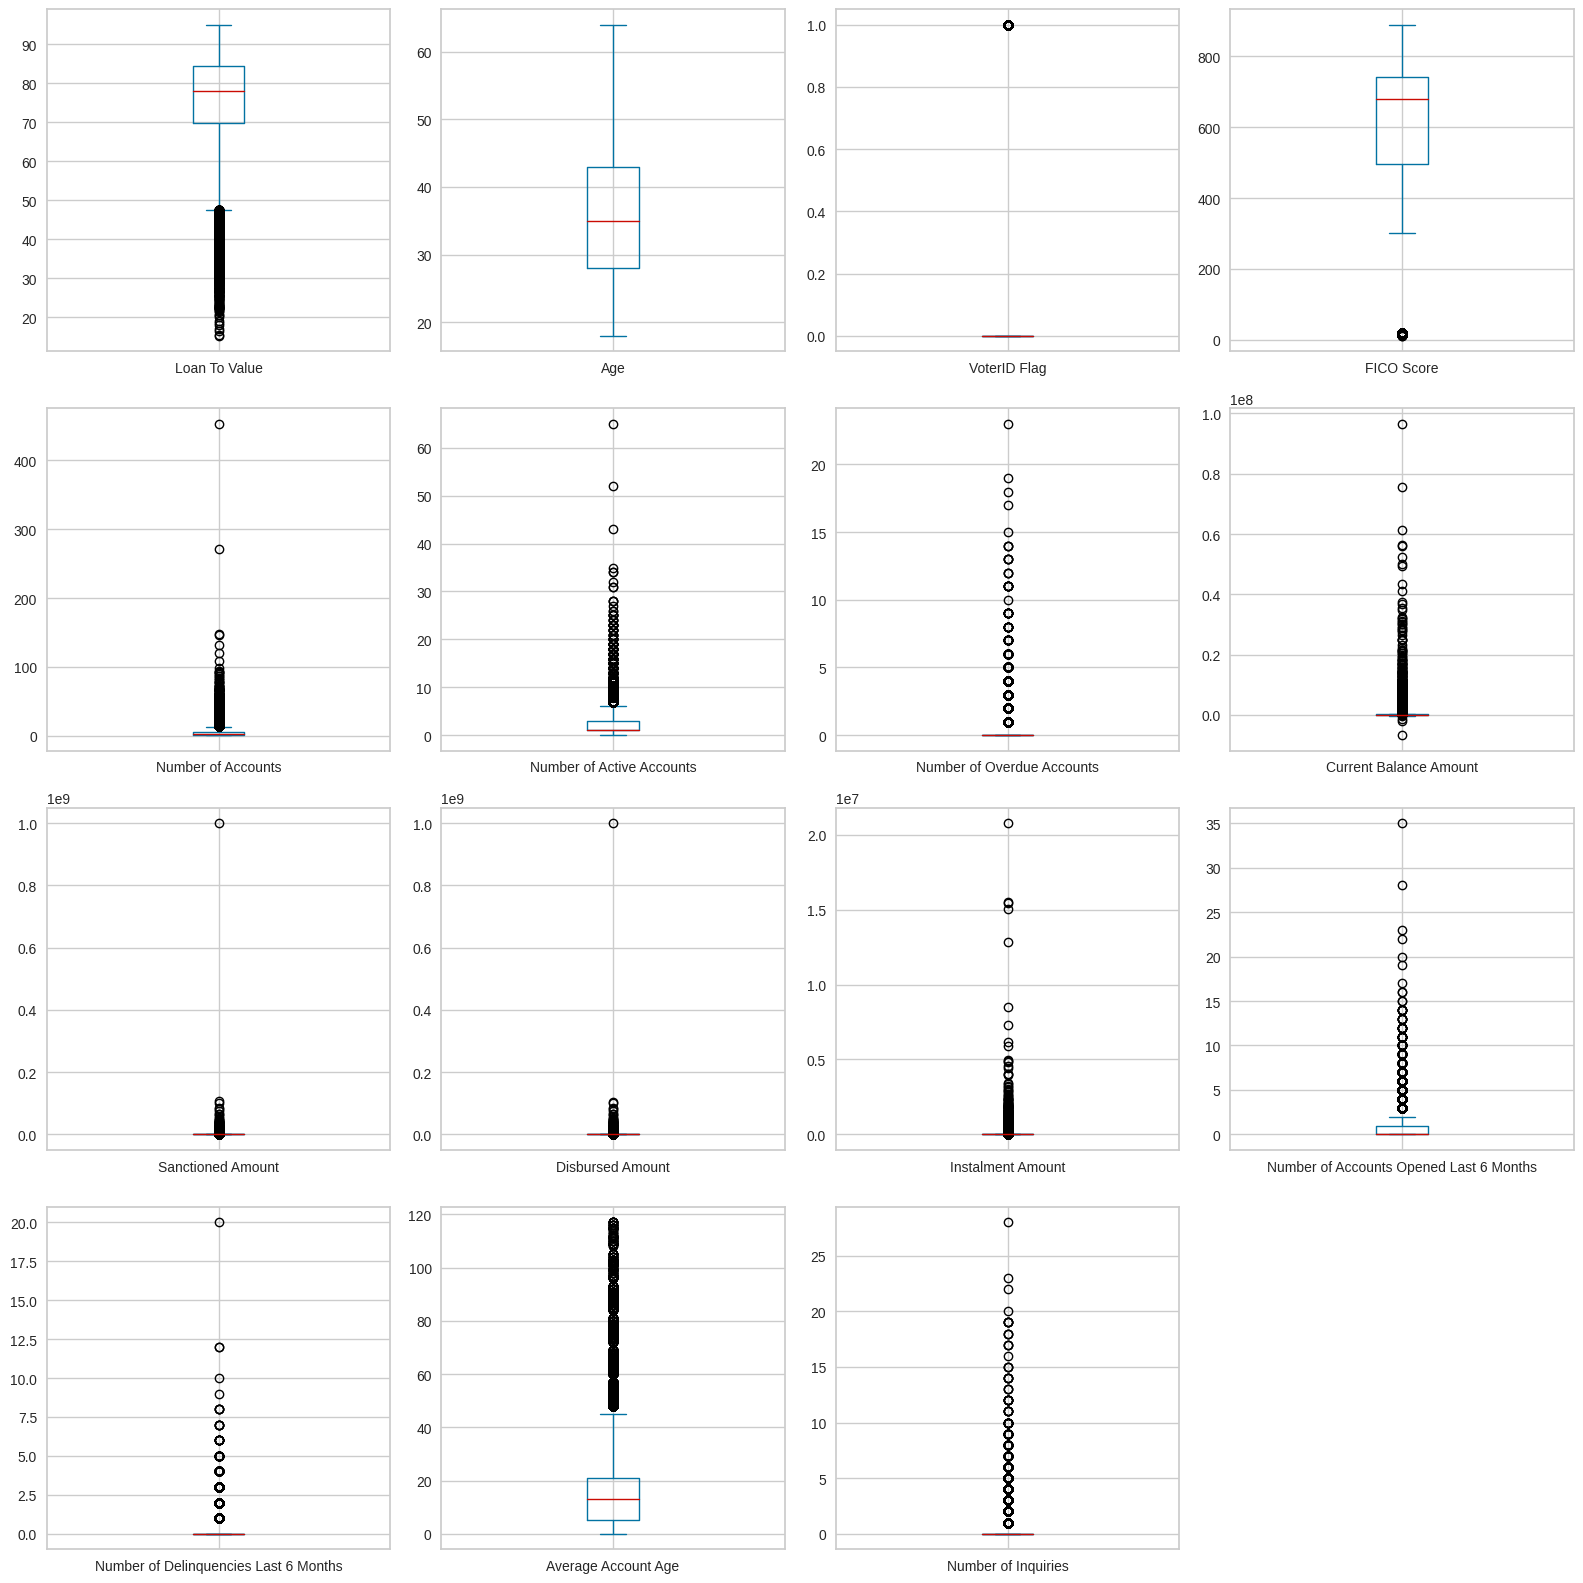

In [ ]:
show_numerical_variable_boxplot(df, layout=(4,4), figsize=(16,16))

Conclutions:
- Identifying outliers -> We should understand about each features and treat outlier with IQR
- Removing the user with the highest disbursed amount will also eliminate another outlier among the other features
- Since we are exploring the home loan portfolio, the FICO Score stands out as one of the important features, globally standardized for its values. However, there are clear anomalies in the FICO Score, given that the range is expected to be within 300 - 850. Therefore, it is necessary to remove these anomalies for users whose FICO Score falls below 300
<br>

**Action Plans**:
- Manage scaler for outliers
- Drop the users with FICO Score below 300
- Drop the users with the highest disbursed amount

### The distribution of disbursed amounts over time

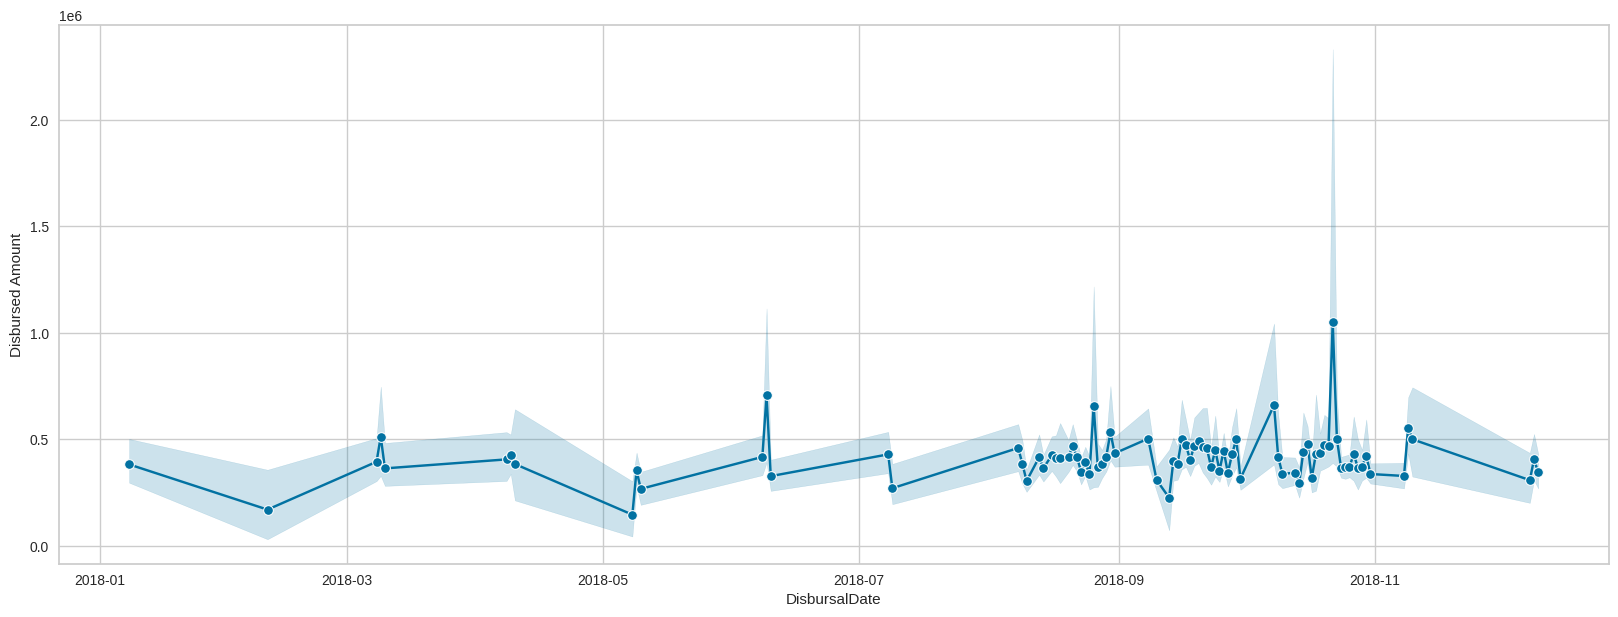

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
sns.lineplot(x="DisbursalDate", y="Disbursed Amount", marker="o", data=df, ax=ax)
plt.show()
# fig = px.line(df, x="DisbursalDate", y="Disbursed Amount", title='Disbursed amount distribution over time')
# fig.show()

**Conclution**: Transaction frequency was higher within August to November; It appears that treating the month as an ordinal variable would be more suitable than categorizing it
<br>
**Action Plan**: Using the month as a feature, it appears that months can effectively represent transaction sessions

### Feature Correlations

In [ ]:
df_num = df.select_dtypes(include='number')
df_corr = df_num.corr()

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = df_corr.columns,
        y = df_corr.index,
        z = np.array(df_corr),
        text=df_corr.values,
        colorscale=px.colors.diverging.RdBu,
        texttemplate='%{text:.2f}'
    )
)
fig.show()

**Correlation is not caucasion**

In [ ]:
# Sanctioned Amount vs Disbursed Amount
fig = px.scatter(df, x='Sanctioned Amount', y='Disbursed Amount')
fig.show()

In [ ]:
## Voter vs Loan To Value
fig = px.box(df, x="VoterID Flag", y="Loan To Value")
fig.show()

**Conclutions**:
1. Non-voters are likely have higher LTV than the voters
2. Lenders are likely to disburse the amount similar to the sanctioned amount
3. The FICO Score doesn't impact other features; the correlation score seems constant
<br>
**Action plan**:
1. Drop sanctioned amount column since it has positive correlation with disbursed amount

## Clustering

Now, we're going to try and use k-means to identify the different groups among the applicants

### Data Preparation

Plans:
1. Drop the users with FICO Score below 300
2. Drop the user with the highest disbursed amount
3. Drop sanctioned amount column since it has positive correlation with disbursed amount
4. Set VoterID Flag into string type
5. Using the month as a feature, it appears that months can effectively represent transaction sessions

In [ ]:
train = df.copy()

In [ ]:
#1. Drop the users with FICO Score below 300
train = train[train['FICO Score'] > 300].reset_index(drop=True)

#2. Drop the user with the highest disbursed amount
train = train[train['Disbursed Amount'] < 0.2*1e9].reset_index(drop=True)

#3. Drop sanctioned amount column since it has positive correlation with disbursed amount
# train = train.drop(['Sanctioned Amount'], axis=1)

# #4. Set VoterID Flag into string type
# train['VoterID Flag'] = train['VoterID Flag'].astype(str)

#5. Using the month as a feature, it appears that months can effectively represent transaction sessions
train['Month'] = train['DisbursalDate'].dt.strftime('%m')
train['Month'] = train['Month'].astype(int)


### Feature Selection

In [ ]:
features = ['Age', 'Employment Type', 'Average Account Age', 'VoterID Flag', 'FICO Score']

_train = train[features].copy()
# Build transformer for each data type consideration
numeric_features = list(_train.select_dtypes(
    include='number'
).columns)
categorical_features = list(_train.select_dtypes(include=["object"]).columns)
X = _train[numeric_features + categorical_features]

### Model Pipeline

Plans:
1. We will fill the NaN values with 'Missing'
2. Manage standardize scaler for outliers

In [ ]:
# Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy = 'median')),
    ('standard_scaler', StandardScaler()),
    ]
)

categorical_transformer = Pipeline(steps=[
    ('imputer_1', SimpleImputer(missing_values=np.nan, strategy = 'constant', fill_value='Missing')),
    ('imputer_2', SimpleImputer(missing_values=None, strategy = 'constant', fill_value='Missing')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

kmeans = Pipeline(
    steps=[
        ('sampling_pipeline', preprocessor),
        ('clustering', KMeans(random_state=4321)),
    ]
)

pca = Pipeline(
    steps=[
        ('sampling_pipeline', preprocessor),
        ('clustering', PCA(random_state=4321)),
    ]
)

### KMeans

In [ ]:
start = 2
n_clusters=10
# elbow criterion methods
wcss = []
# silhouette coef
silhouette_scores = []
for i in range(start, n_clusters):
    print(f"n_clusters: {i}")
    # elbow
    kmeans_ = kmeans.set_params(clustering__n_clusters=i)
    kmeans_.fit(X)
    wcss.append(kmeans_.named_steps['clustering'].inertia_)

n_clusters: 2
n_clusters: 3
n_clusters: 4
n_clusters: 5
n_clusters: 6
n_clusters: 7
n_clusters: 8
n_clusters: 9


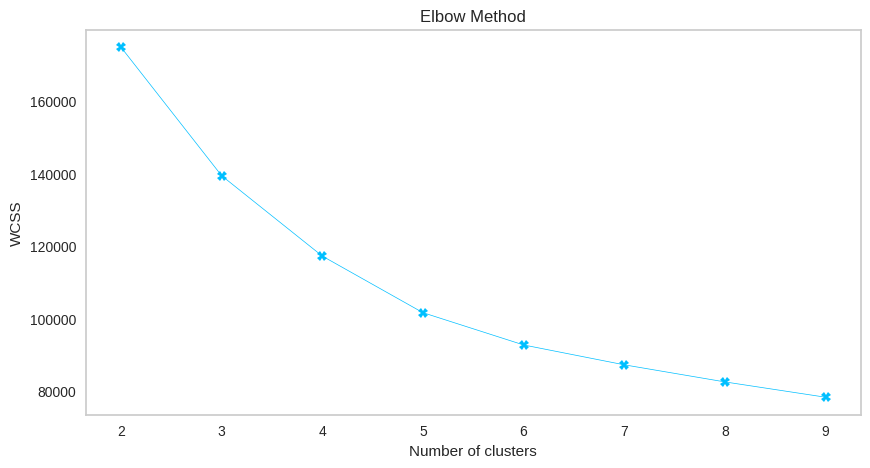

In [ ]:
k = [i for i in range(start, n_clusters)]

plt.figure(figsize=(10,5))
plt.plot(k, wcss, marker='X', lw = 0.5, color = 'deepskyblue')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

n_clusters: 2


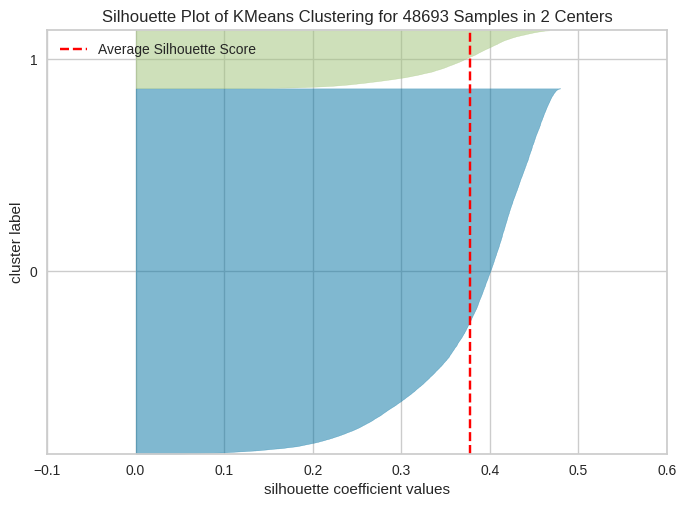

n_clusters: 3


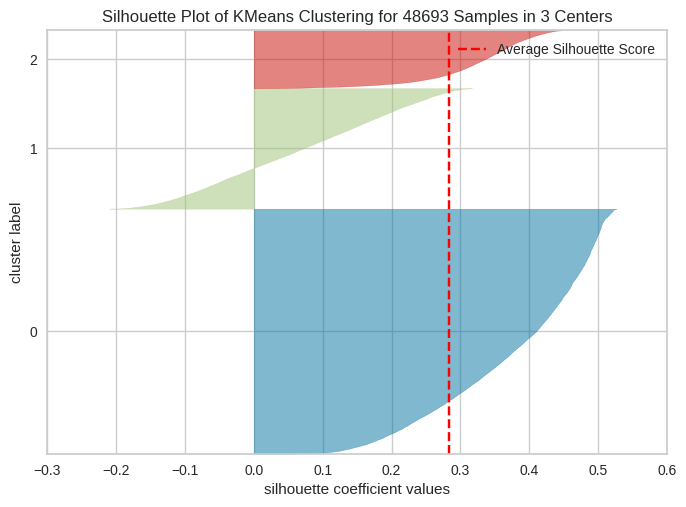

n_clusters: 4


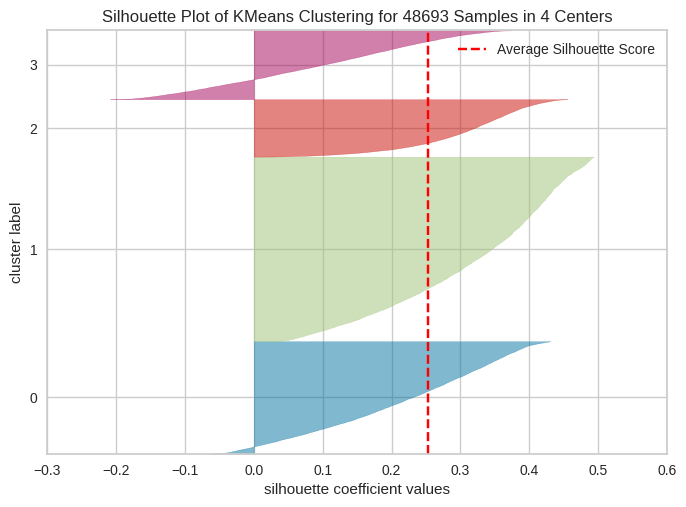

n_clusters: 5


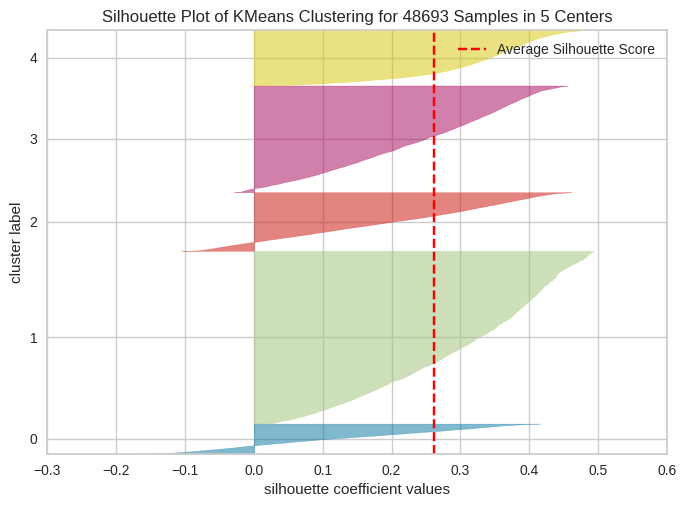

n_clusters: 6


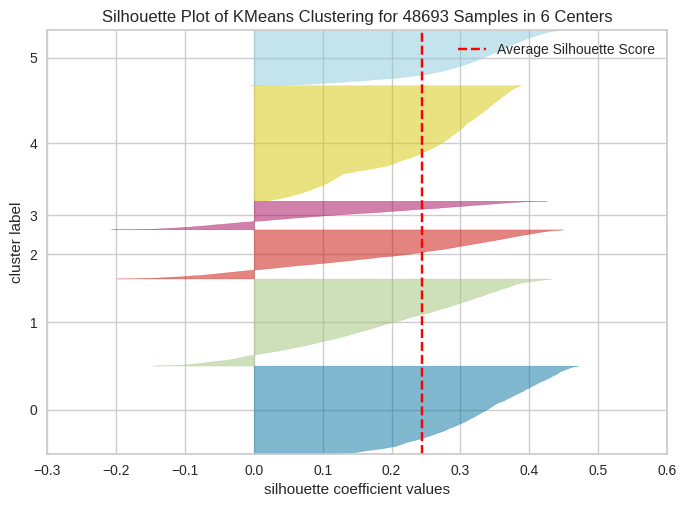

n_clusters: 7


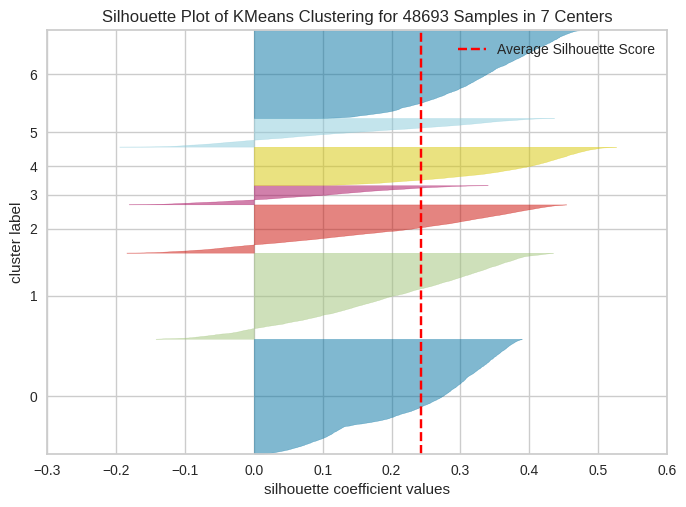

n_clusters: 8


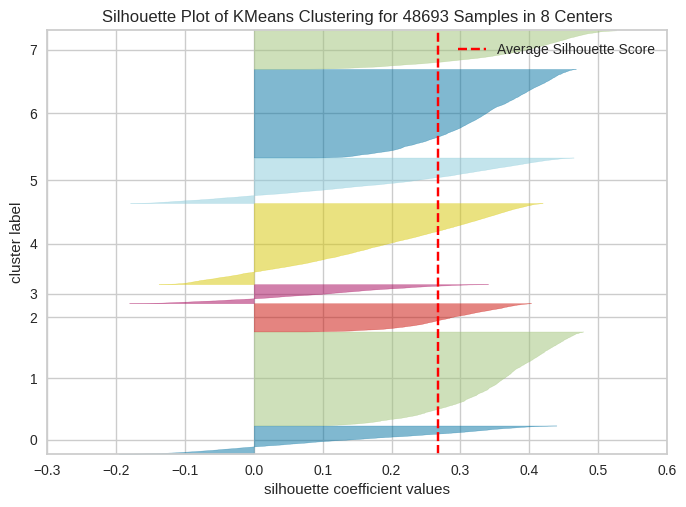

n_clusters: 9


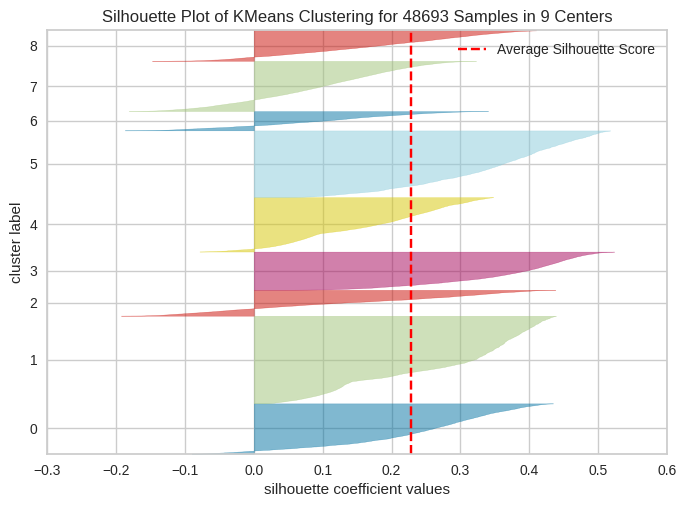

In [ ]:
for i in range(start, n_clusters):
    print(f"n_clusters: {i}")
    kmeans_ = kmeans.set_params(clustering__n_clusters=i)
    kmeans_.fit(X)
    visualizer = silhouette_visualizer(kmeans_.named_steps['clustering'], preprocessor.fit_transform(X), colors = 'yellowbrick')
    visualizer.show()

Using the silhouette method, it seems that 5 is the optimal value for k, since all the clusters are above the average silhouette score and they appear to be in quite similar sizes.

Thus, we will continue with k = 5.

In [ ]:
kmeans_5_clusters = kmeans.set_params(clustering__n_clusters=5)
kmeans_5_clusters.fit(X)

Pipeline(steps=[('sampling_pipeline',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Average Account Age',
                                                   'VoterID Flag',
                                                   'FICO Score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer_1',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('imputer_2',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 missing_values=None,
                                                                                 strategy='constant')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment Type'])])),
                ('clustering', KMeans(n_clusters=5, random_state=4321))])

In [ ]:
score = silhouette_score(preprocessor.fit_transform(X), kmeans_5_clusters.named_steps['clustering'].labels_, metric='euclidean')
print(f"Silhoutte Score for Kmeans = {score}")

Silhoutte Score for Kmeans = 0.2608650226639092


The silhouette score of this model is about 0.26.

This isn't a bad model, but we can do better and try getting higher cluster separation.

### PCA

In [ ]:
# pca = Pipeline(
#     steps=[
#         ('sampling_pipeline', preprocessor),
#         ('clustering', PCA(random_state=4321)),
#     ]
# )

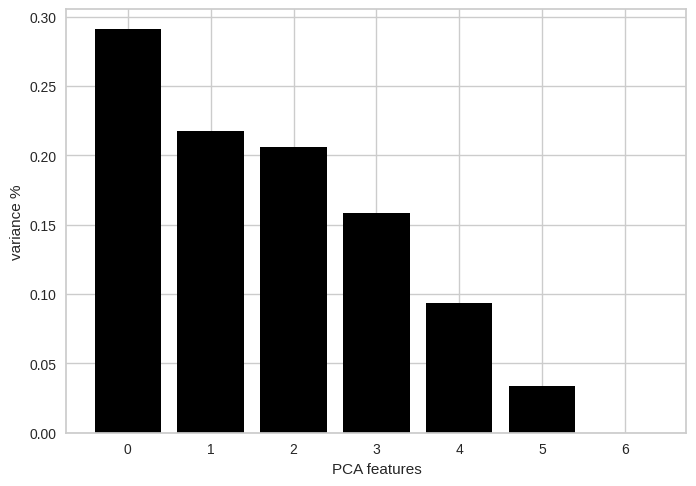

In [ ]:
principalComponents = pca.fit_transform(X)

features = range(pca.named_steps['clustering'].n_components_)
plt.bar(features, pca.named_steps['clustering'].explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. We can see that the first three PCA components explain around 70% of the dataset variance. So, in this instance, we decide to keep 3 components.

In [ ]:
start = 2
n_clusters=10
# elbow criterion methods
wcss = []
# silhouette coef
silhouette_scores = []
for i in range(start, n_clusters):
    print(f"n_clusters: {i}")
    # elbow
    kmeans_pca = KMeans(n_clusters=k, random_state=4321)
    kmeans_pca = kmeans_pca.set_params(n_clusters=i)
    kmeans_pca.fit(PCA_components.iloc[:,:3]) ## Keep 3 components
    wcss.append(kmeans_pca.inertia_)

n_clusters: 2
n_clusters: 3
n_clusters: 4
n_clusters: 5
n_clusters: 6
n_clusters: 7
n_clusters: 8
n_clusters: 9


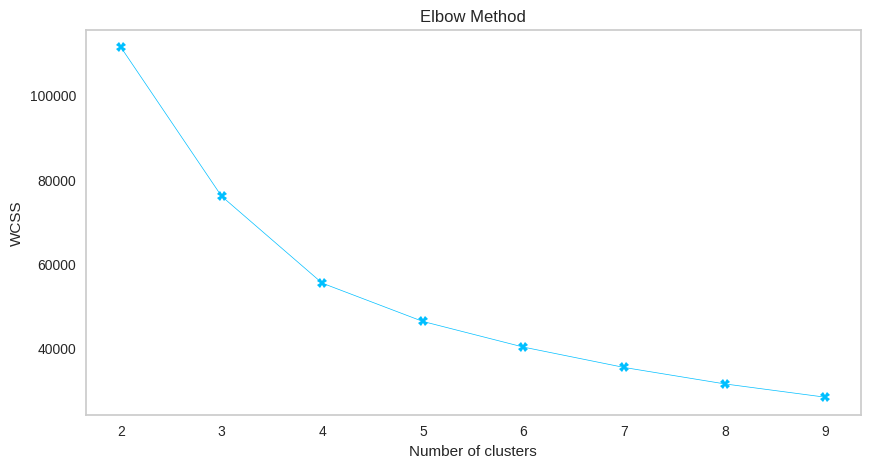

In [ ]:
k = [i for i in range(start, n_clusters)]

plt.figure(figsize=(10,5))
plt.plot(k, wcss, marker='X', lw = 0.5, color = 'deepskyblue')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [ ]:
kmeans_pca_5_clusters = KMeans(n_clusters=5, random_state=4321)
kmeans_pca_5_clusters.fit(PCA_components.iloc[:,:3])

KMeans(n_clusters=5, random_state=4321)

In [ ]:
score = silhouette_score(PCA_components.iloc[:,:3], kmeans_pca_5_clusters.labels_, metric='euclidean')
print(f"Silhoutte Score for Kmeans = {score}")

Silhoutte Score for Kmeans = 0.3877820872261346


### Comparison

In [ ]:
# Tranformed X data
_X = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())
# Copy X data
X_copy = X.copy()
sample = X_copy.sample(frac=0.05)
sample_principalComponents = pca.fit_transform(sample)
sample_PCA_components = pd.DataFrame(sample_principalComponents)

#### KMeans Vizualisation

In [ ]:
clusters = kmeans_5_clusters.fit_predict(sample)
sample.loc[:, "label"] = clusters
sample["label"] = sample["label"].astype(str)

fig = px.scatter_3d(sample, x='FICO Score', y='Age', z='Average Account Age', color='label')
fig.show()

#### PCA Vizualisation

In [ ]:
clusters = kmeans_pca_5_clusters.fit_predict(sample_PCA_components.iloc[:,:3])
sample.loc[:, "label"] = clusters
sample["label"] = sample["label"].astype(str)

fig = px.scatter_3d(sample, x='FICO Score', y='Age', z='Average Account Age', color='label')
fig.show()

<ipython-input-178-1b8173ce3861>:2: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



Notice that the clusters in the second model (with PCA) are much better separated than that in the first model.

The clusters in first model overlap significantly with each other.

Furthermore, the silhouette score of the second model (with PCA) is a lot higher.

For these reasons, we can pick the second model to go forward with our analysis.

## Cluster Analysis

In [ ]:
X_principalComponents = pca.fit_transform(X)
X_PCA_components = pd.DataFrame(X_principalComponents)
clusters = kmeans_pca_5_clusters.fit_predict(X_PCA_components.iloc[:,:3])

In [ ]:
X.loc[:, "label"] = clusters
X["label"] = X["label"].astype(str)
X.head()

<ipython-input-182-8b2ef23cf7ae>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-182-8b2ef23cf7ae>:1: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-182-8b2ef23cf7ae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Age  Average Account Age  VoterID Flag  FICO Score Employment Type label
0   25                    8             0         305   Self employed     3
1   28                   21             0         825   Self employed     4
2   27                   56             0         718   Self employed     3
3   50                   19             1         818        Salaried     2
4   34                   25             0         786        Salaried     1

To compare attributes of the different clusters, lets find the average of all variables across each cluster:

In [ ]:
avg_df = X.groupby(['label'], as_index=False).mean()
avg_df

label        Age  Average Account Age  VoterID Flag  FICO Score
0     0  47.152420            45.673859      0.057261  573.911480
1     1  44.171938            16.149808      0.000000  743.699364
2     2  35.640502            16.528100      1.000000  690.939774
3     3  32.895869            18.246912      0.000266  528.778324
4     4  29.164986             7.976672      0.000000  732.765956

Interpret these clusters more easily if we visualized them

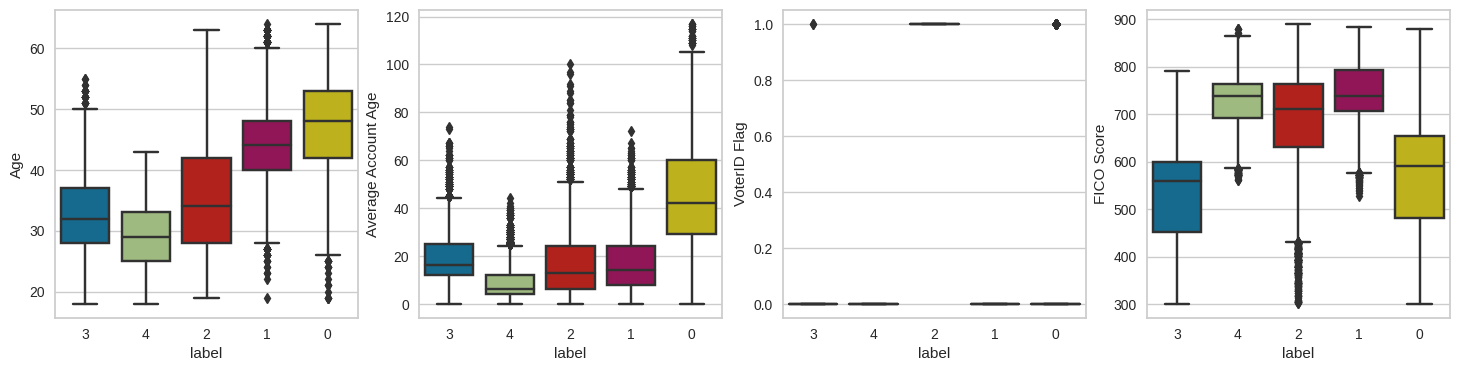

In [ ]:
show_multivariate_boxplot(data=X, layout=(4,1), figsize=(18,4), target='label')

Employment type breakdown

In [ ]:
employment_type_df = pd.DataFrame(X.groupby(['label','Employment Type'])['Employment Type'].count())
employment_type_df

Employment Type
label Employment Type                 
0     Missing                       35
      Salaried                    1318
      Self employed               1947
1     Missing                      116
      Salaried                    4946
      Self employed               6482
2     Missing                       93
      Salaried                    2342
      Self employed               3519
3     Missing                      203
      Salaried                    2872
      Self employed               3627
4     Missing                      570
      Salaried                    8760
      Self employed               7151

#### Main attributes of each segment

**Cluster 0:**

Mid-average FICO Score, high average account age.
The mean age is around 47, with a majority being non-voters, and the predominant employment type is self-employed

**Cluster 1:**

High-average FICO Score, mid average account age.
The mean age is around 44, with a majority being non-voters, and the predominant employment type is self-employed

**Cluster 2:**

High-average FICO Score, mid average account age.
The mean age is around 35, with a majority being voters, and the predominant employment type is self-employed

**Cluster 3:**

Low-average FICO Score, mid average account age.
The mean age is around 32, with a majority being non-voters, and the predominant employment type is self-employed

**Cluster 4:**

High-average FICO Score, low average account age.
The mean age is around 29, with a majority being non-voters, and the predominant employment type is salaried employee



## Personas and Conclusion

**Cluster 0: Almost retired**

This segment comprises of an older group of people.

They tend to have a moderate FICO Score, which might be attributed to their propensity for saving a significant portion of their income for retirement

*Recommendation: Marketing to these individuals can be done through Facebook, which appeals to an older demographic. Promote healthcare related products to people in this segment.*

**Cluster 1: The bosses**

This segment comprises an older group of people with high FICO Score

This might be because they are still active in their jobs. Additionally, given their age, they likely hold high-level positions within their respective companies, which enables them to maintain their FICO scores

*Recommendation: Due to their high FICO score and their demographic, these individuals are likely to be looking for properties to buy or invest in. They are also more likely than all other segments to take out housing loans and make serious financial commitments.*

**Cluster 2: Political enthusiasts**

This segment consists of middle-aged individuals who actively participate as voters

These enthusiastic middle-aged individuals are interested in politics, and they might even be politicians, which could explain their high FICO scores

*Recommendation: Given these individuals' interest in politics, product recommendations can vary based on their specific financial goals, risk tolerance, and political views. However, we can offer them customized solutions, including flexible loan options that cater to a variety of needs, such as different down payment requirements, interest rate options, and terms.*


**Cluster 3: Financially struggling**

This segment consists of a middle-age group with low FICO scores, often resulting from their failure to meet loan repayment responsibilities.

These individuals are facing challenges with their credit history and loan repayment. They tend to spend above their means.

*Recommendation: Budgeting Tools will help this segment to manage their finances effectively and track their spending.*




**Cluster 4: New homeowners**

This segment consists of younger age group who have recently taken out a mortgage

Individuals in this segment are most likely first jobbers. They make some amount of money to take a mortage for after obtaining a job.

*Recommendation: Since these group of people are young, they need a personalized communication: Implement personalized email campaigns addressing common concerns of young homeowners, such as building equity, managing mortgage payments, and optimizing their financial future.*




### Conclusions

We have successfully built a K-Means clustering model for customer segmentation. We also explored cluster interpretation, and analyzed the behaviour of individuals in each cluster.